# Titanic — Full Pipeline Notebook

This notebook implements a complete pipeline for the Kaggle **Titanic: Machine Learning from Disaster** problem:

- Exploratory Data Analysis (EDA)
- Three missing-value strategies: **median**, **group-median**, **predictive (model-based)**
- Feature engineering (detailed)
- Creation of separate CSVs for each variant
- Training and evaluating multiple models per variant (Logistic Regression, RandomForest, XGBoost if available)
- Exporting a results summary CSV

Each step contains explanatory markdown and runnable code cells. **Run cells in order.**

Place `train.csv` (Kaggle train file) in the same folder as this notebook before running.


In [12]:
# If you're running locally and missing packages, uncomment and run the following:
# !pip install xgboost==1.7.6

import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Optional XGBoost import (if installed)
try:
    from xgboost import XGBClassifier
    xgb_available = True
except Exception:
    xgb_available = False

RANDOM_STATE = 42
print('xgboost available:', xgb_available)


xgboost available: True


## 2. Load data

Read `train.csv` and inspect basic structure.

In [13]:
if not os.path.exists('C:\\Users\\hienm\\OneDrive\\Documents\\titanic_ML\\train.csv'):
    raise FileNotFoundError('train.csv not found in the working directory. Please upload it before running.')

train = pd.read_csv('train.csv')
print('train shape:', train.shape)
train.head()


train shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 3. Exploratory Data Analysis (EDA)

Check missing values and basic distributions.

Missing values per column:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


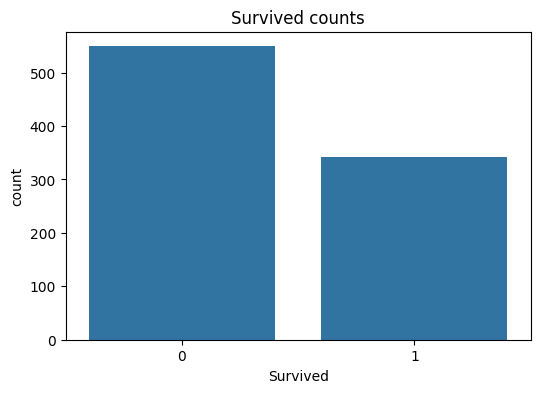

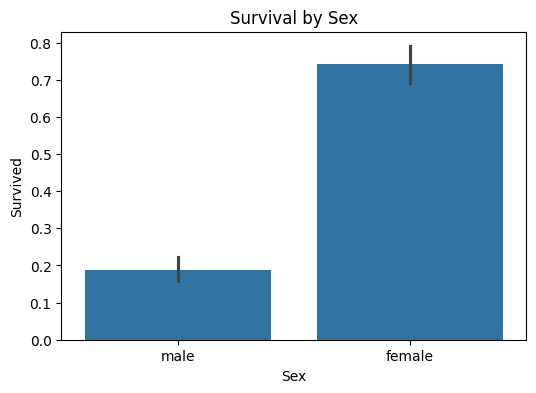

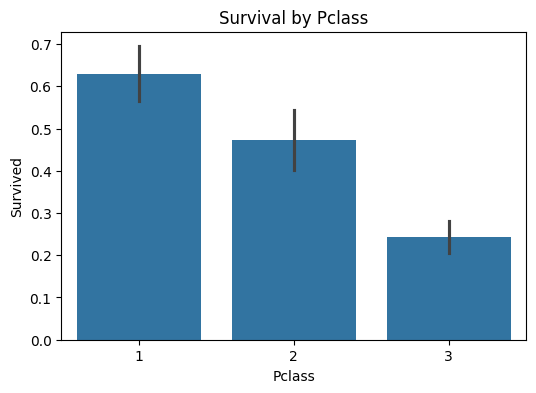

In [14]:
print('Missing values per column:')
print(train.isnull().sum())

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='Survived', data=train)
plt.title('Survived counts')
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(x='Sex', y='Survived', data=train)
plt.title('Survival by Sex')
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(x='Pclass', y='Survived', data=train)
plt.title('Survival by Pclass')
plt.show()


## 4. Three missing-value strategies (overview)

We'll create three *variants* of the train dataset:

1. **Median Impute** — simple fills using median/mode.
2. **Group Median** — fills using median within groups (Sex x Pclass), more contextual.
3. **Model Predictive** — use models (RandomForest) trained on known rows to predict missing values.

We will save each variant to a separate CSV for reproducibility and to test models on identical downstream features.

### 4.1 Variant A — Median imputation

In [15]:
df_median = train.copy()
# Age, Fare median; Embarked mode; Cabin -> HasCabin flag
df_median['Age'] = df_median['Age'].fillna(df_median['Age'].median())
df_median['Fare'] = df_median['Fare'].fillna(df_median['Fare'].median())
df_median['Embarked'] = df_median['Embarked'].fillna(df_median['Embarked'].mode()[0])
df_median['HasCabin'] = df_median['Cabin'].notnull().astype(int)
df_median = df_median.drop(columns=['Cabin'])
df_median.to_csv('train_variant_median.csv', index=False)
print('Saved train_variant_median.csv — shape', df_median.shape)
df_median.head()


Saved train_variant_median.csv — shape (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,HasCabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0


### 4.2 Variant B — Group-median imputation (Sex x Pclass)

In [16]:
df_group = train.copy()
df_group['HasCabin'] = df_group['Cabin'].notnull().astype(int)

# Map Sex temporarily for grouping
df_group['_sex_num'] = df_group['Sex'].map({'male':0,'female':1})

# Age filled by group median
df_group['Age'] = df_group.groupby(['_sex_num','Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))
df_group['Age'] = df_group['Age'].fillna(df_group['Age'].median())

# Fare by Pclass median
df_group['Fare'] = df_group.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))
df_group['Fare'] = df_group['Fare'].fillna(df_group['Fare'].median())

# Embarked mode fill
df_group['Embarked'] = df_group['Embarked'].fillna(df_group['Embarked'].mode()[0])

df_group = df_group.drop(columns=['Cabin','_sex_num'])
df_group.to_csv('train_variant_group.csv', index=False)
print('Saved train_variant_group.csv — shape', df_group.shape)
df_group.head()



Saved train_variant_group.csv — shape (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,HasCabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0


### 4.3 Variant C — Predictive (model) imputation

In [17]:
df_model = train.copy()

# Create HasCabin
df_model['HasCabin'] = df_model['Cabin'].notnull().astype(int)

# Prepare Sex numeric for models
df_model['_Sex_num'] = df_model['Sex'].map({'male':0,'female':1})

# Ensure Fare has no missing (we'll fill with median temporarily so Age model can use it)
df_model['Fare'] = df_model['Fare'].fillna(df_model['Fare'].median())

# Predict Age
age_train = df_model[df_model['Age'].notnull()]
age_pred = df_model[df_model['Age'].isnull()]

age_features = ['Pclass','_Sex_num','SibSp','Parch','Fare','HasCabin']
if len(age_pred) > 0 and len(age_train) > 0:
    rfr = RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE)
    rfr.fit(age_train[age_features], age_train['Age'])
    df_model.loc[df_model['Age'].isnull(), 'Age'] = rfr.predict(age_pred[age_features])
else:
    print('No missing Age to predict or insufficient data.')

# Encode Embarked temporarily (only for training the classifier)
emb_map = {'S':0, 'C':1, 'Q':2}
df_model['_Embarked_enc'] = df_model['Embarked'].map(emb_map)

emb_train = df_model[df_model['_Embarked_enc'].notnull()]
emb_pred = df_model[df_model['_Embarked_enc'].isnull()]

emb_features = ['Pclass','_Sex_num','SibSp','Parch','Fare','Age','HasCabin']
if len(emb_pred) > 0 and len(emb_train) > 0:
    clf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
    clf.fit(emb_train[emb_features], emb_train['_Embarked_enc'])
    df_model.loc[df_model['_Embarked_enc'].isnull(), '_Embarked_enc'] = clf.predict(emb_pred[emb_features])
    # Map back to original labels
    inv_map = {v:k for k,v in emb_map.items()}
    df_model['Embarked'] = df_model['_Embarked_enc'].map(inv_map)
else:
    df_model['Embarked'] = df_model['Embarked'].fillna(df_model['Embarked'].mode()[0])

# Cleanup
df_model = df_model.drop(columns=['Cabin','_Sex_num','_Embarked_enc'])
df_model.to_csv('train_variant_model.csv', index=False)
print('Saved train_variant_model.csv — shape', df_model.shape)
df_model.head()


Saved train_variant_model.csv — shape (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,HasCabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0


#### Update feature engineering

In [18]:

try:
    df = train.copy()
except:
    pass

print(" Bắt đầu Feature Engineering...")

# 1️ FamilySize - tổng số người trong gia đình
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# 2️ IsAlone - có đi một mình không
df['IsAlone'] = 0
df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

# 3️ Title - trích xuất danh xưng từ Name
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = df['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr','Major',
                                   'Rev','Sir','Jonkheer','Dona'], 'Rare')
df['Title'] = df['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})

# 4️ FarePerPerson - chia giá vé theo số người
df['FarePerPerson'] = df['Fare'] / df['FamilySize']

# 5️ Deck - ký tự đầu của Cabin
df['Deck'] = df['Cabin'].astype(str).str[0]
df['Deck'] = df['Deck'].replace('n', 'Unknown')

# 6️ TicketPrefix - nhóm ký tự trước số trong Ticket
df['TicketPrefix'] = df['Ticket'].apply(lambda x: ''.join([c for c in x if not c.isdigit()]).strip().replace('.', '').replace('/', ''))
df['TicketPrefix'] = df['TicketPrefix'].replace('', 'None')

# 7️ Nhóm các giá trị hiếm để tránh quá nhiều biến dummy
rare_titles = df['Title'].value_counts()[df['Title'].value_counts() < 10].index
df['Title'] = df['Title'].replace(rare_titles, 'Rare')

rare_decks = df['Deck'].value_counts()[df['Deck'].value_counts() < 10].index
df['Deck'] = df['Deck'].replace(rare_decks, 'Rare')

# 8️ AgeBin và FareBin - phân nhóm tuổi và giá vé
df['AgeBin'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 80], 
                      labels=['Child','Teen','Adult','MidAge','Senior'])
df['FareBin'] = pd.qcut(df['Fare'], 4, 
                        labels=['Low','Mid','High','VeryHigh'])

# 9️ Chuyển sang dạng category cho các cột phân loại
categorical_cols = ['Sex','Embarked','Title','Deck','TicketPrefix','AgeBin','FareBin']
for col in categorical_cols:
    df[col] = df[col].astype('category')

# ✅ Lưu lại để dễ so sánh sau
df.to_csv("titanic_feature_v1.csv", index=False)

print("🎉 Feature Engineering hoàn tất! Tổng số cột sau khi tạo:", len(df.columns))
print("Các cột mới:", [c for c in df.columns if c not in ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']])


 Bắt đầu Feature Engineering...
🎉 Feature Engineering hoàn tất! Tổng số cột sau khi tạo: 20
Các cột mới: ['FamilySize', 'IsAlone', 'Title', 'FarePerPerson', 'Deck', 'TicketPrefix', 'AgeBin', 'FareBin']


## 5. Feature Engineering (apply to each variant)

In [19]:
def feature_engineer(df, save_path=None):
    df = df.copy()
    # Family features
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    # Title
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\\.', expand=False)
    df['Title'] = df['Title'].replace(['Mlle','Ms'],'Miss').replace(['Mme'],'Mrs')
    df['Title'] = df['Title'].replace([
        'Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'
    ], 'Rare')
    df['Title'] = df['Title'].map({'Mr':1,'Miss':2,'Mrs':3,'Master':4,'Rare':5}).fillna(0)

    # TicketPrefix
    df['TicketPrefix'] = df['Ticket'].apply(lambda x: x.split()[0] if len(x.split())>1 else 'None')
    top_prefix = df['TicketPrefix'].value_counts().nlargest(10).index
    df['TicketPrefix'] = df['TicketPrefix'].apply(lambda x: x if x in top_prefix else 'Other')

    # AgeBin, FareBin
    df['AgeBin'] = pd.cut(df['Age'], bins=[0,12,20,35,50,65,100], labels=[0,1,2,3,4,5])
    try:
        df['FareBin'] = pd.qcut(df['Fare'], 4, labels=[0,1,2,3])
    except ValueError:
        df['FareBin'] = pd.cut(df['Fare'], bins=4, labels=[0,1,2,3])

    df = df.drop(columns=['PassengerId','Name','Ticket'], errors='ignore')
    if save_path:
        df.to_csv(save_path, index=False)
    
    return df

# Apply to each variant
fe_median = feature_engineer(df_median, save_path='train_median_features.csv')
fe_group = feature_engineer(df_group, save_path='train_group_features.csv')
fe_model = feature_engineer(df_model, save_path='train_model_features.csv')

print('Saved 3 feature CSVs: train_median_features.csv, train_group_features.csv, train_model_features.csv')


Saved 3 feature CSVs: train_median_features.csv, train_group_features.csv, train_model_features.csv


In [20]:
from sklearn.model_selection import train_test_split

def split_and_save(df, variant_name, test_size=0.2, random_state=RANDOM_STATE):
    """
    Chia dataset thành train và validation, đảm bảo stratify theo 'Survived'.
    """
    X_train, X_val, y_train, y_val = train_test_split(
        df.drop(columns=['Survived']),
        df['Survived'],
        test_size=test_size,
        random_state=random_state,
        stratify=df['Survived']
    )
    
    # Ghép lại để lưu thành CSV
    train_df = pd.concat([X_train, y_train], axis=1)
    val_df = pd.concat([X_val, y_val], axis=1)
    
    train_path = f'{variant_name.lower().replace(" ", "_")}_train.csv'
    val_path = f'{variant_name.lower().replace(" ", "_")}_val.csv'
    
    train_df.to_csv(train_path, index=False)
    val_df.to_csv(val_path, index=False)
    
    print(f'✅ Saved {train_path} ({train_df.shape}) and {val_path} ({val_df.shape})')
    return train_df, val_df

# Áp dụng cho 3 biến thể
median_train, median_val = split_and_save(fe_median, 'Median Impute')
group_train, group_val = split_and_save(fe_group, 'Group Impute')
model_train, model_val = split_and_save(fe_model, 'Model Impute')

✅ Saved median_impute_train.csv ((712, 15)) and median_impute_val.csv ((179, 15))
✅ Saved group_impute_train.csv ((712, 15)) and group_impute_val.csv ((179, 15))
✅ Saved model_impute_train.csv ((712, 15)) and model_impute_val.csv ((179, 15))


## 6. Encoding & Modeling

In [21]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.exceptions import NotFittedError
import pandas as pd

# Nếu bạn có XGBoost thì bật
try:
    from xgboost import XGBClassifier
    xgb_available = True
except ImportError:
    xgb_available = False

RANDOM_STATE = 42

def evaluate_variant(train_df, val_df, variant_name):
    """Đánh giá 1 biến thể dữ liệu bằng các mô hình khác nhau"""
    results = []

    X_train = train_df.drop('Survived', axis=1)
    y_train = train_df['Survived']
    X_val = val_df.drop('Survived', axis=1)
    y_val = val_df['Survived']

    cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    num_cols = X_train.select_dtypes(exclude=['object', 'category']).columns.tolist()

    pre = ColumnTransformer(transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_cols)
    ], remainder='passthrough')

    models = {
        'Logistic': LogisticRegression(max_iter=500, random_state=RANDOM_STATE),
        'RandomForest': RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
    }

    if xgb_available:
        try:
            models['XGBoost'] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)
        except Exception as e:
            print("⚠️ XGBoost initialization failed:", e)

    # 🟢 Voting Classifier (giữ nguyên như bạn yêu cầu)
    estimators = [(k, v) for k, v in models.items()]
    voting_clf = VotingClassifier(estimators=estimators, voting='soft')

    # Gộp tất cả để đánh giá cùng format
    models['Voting'] = voting_clf

    for name, mdl in models.items():
        try:
            pipe = Pipeline([('pre', pre), ('model', mdl)])
            pipe.fit(X_train, y_train)
            preds = pipe.predict(X_val)
            acc = accuracy_score(y_val, preds)
            print(f"✅ {variant_name} | {name} Accuracy: {acc:.4f}")
            results.append({'Variant': variant_name, 'Model': name, 'Accuracy': acc})
        except AttributeError as e:
            if "__sklearn_tags__" in str(e):
                print(f"⚠️ Skipping {name} (sklearn_tags incompatibility - Python 3.13 issue)")
                continue
            else:
                raise e
        except Exception as e:
            print(f"❌ {variant_name} | {name} failed: {e}")
            continue

    return results

# ============================================
#  🔹 Đọc lại các bộ dữ liệu đã chia
# ============================================
median_train = pd.read_csv('median_impute_train.csv')
median_val   = pd.read_csv('median_impute_val.csv')
group_train  = pd.read_csv('group_impute_train.csv')
group_val    = pd.read_csv('group_impute_val.csv')
model_train  = pd.read_csv('model_impute_train.csv')
model_val    = pd.read_csv('model_impute_val.csv')

# ============================================
#  🔹 Đánh giá từng biến thể
# ============================================
results = []
results += evaluate_variant(median_train, median_val, 'Median Impute')
results += evaluate_variant(group_train, group_val, 'Group Impute')
results += evaluate_variant(model_train, model_val, 'Model Impute')

# ============================================
#  🔹 Lưu kết quả
# ============================================
results_df = pd.DataFrame(results)
results_df.to_csv('model_accuracy_summary.csv', index=False)
results_df


✅ Median Impute | Logistic Accuracy: 0.8156
✅ Median Impute | RandomForest Accuracy: 0.8156
✅ Median Impute | XGBoost Accuracy: 0.8324
✅ Median Impute | Voting Accuracy: 0.8268
✅ Group Impute | Logistic Accuracy: 0.8212
✅ Group Impute | RandomForest Accuracy: 0.8101
✅ Group Impute | XGBoost Accuracy: 0.8156
✅ Group Impute | Voting Accuracy: 0.8212
✅ Model Impute | Logistic Accuracy: 0.8101
✅ Model Impute | RandomForest Accuracy: 0.8156
✅ Model Impute | XGBoost Accuracy: 0.8101
✅ Model Impute | Voting Accuracy: 0.8156


,Variant,Model,Accuracy
0,Median Impute,Logistic,0.815642
1,Median Impute,RandomForest,0.815642
2,Median Impute,XGBoost,0.832402
3,Median Impute,Voting,0.826816
4,Group Impute,Logistic,0.821229
5,Group Impute,RandomForest,0.810056
6,Group Impute,XGBoost,0.815642
7,Group Impute,Voting,0.821229
8,Model Impute,Logistic,0.810056
9,Model Impute,RandomForest,0.815642


## 7. Next steps & Tips

- Inspect `model_accuracy_summary.csv` to compare variants and models.
- Re-train best model on full data and use it for final Kaggle submission.
- Try hyperparameter tuning (GridSearchCV) and advanced models (LightGBM/CatBoost).
- Files produced:
  - `train_variant_median.csv`, `train_variant_group.csv`, `train_variant_model.csv`
  - `train_median_features.csv`, `train_group_features.csv`, `train_model_features.csv`
  - `model_accuracy_summary.csv`

Run the notebook end-to-end to produce the CSVs and the summary.
